# **Predicting Disneyland Ride Popularity and Designing an Optimal Park Day Plan**

### **DSC 102 – Assignment 2**

**Author:**  
Kyle Le  

**Project Overview:**  
This project uses historic Disneyland wait-time data to predict ride popularity tiers (1–5) using machine learning models. The predicted popularity scores are then used to generate an optimized ride plan aimed at maximizing high-tier rides within a single park day.


## **1. Predictive Task**

### **Goal**

The goal of this project is to predict the **popularity tier** of each Disneyland ride using historic wait-time data.  
Each ride is assigned a popularity tier from **1 to 5**, where:

- **5** = most popular / in highest demand  
- **1** = least popular / lowest demand  

These tiers may be derived from my own personal tier list that I have created.

---

### **Problem Formulation**

This task is formulated as a **multiclass classification problem**:

- **Input features (X):**  
  Quantitative attributes of a ride, such as:  
  - Average wait time  
  - Maximum wait time  

- **Output label (y):**  
  A discrete popularity tier in **{1, 2, 3, 4, 5}**

The goal is to learn a function:

$$f(X) \rightarrow y$$

that accurately predicts the popularity tier from ride statistics.

---

### **Models to Be Used**

To align with course content, the project includes:

- A **majority-class baseline**  
- A **wait-time heuristic baseline** (ranking rides by average wait time)  
- A **multinomial logistic regression model**  
  - This is the primary ML model used for classification  
  - It outputs predicted probabilities for each tier  

---

### **Evaluation Strategy**

Model performance will be assessed using:

- **Accuracy**  
- **Macro F1-score**  
- **Confusion matrix visualization**  
  - Helps reveal whether errors occur mostly between adjacent tiers (e.g., 3 ↔ 4)

Performance of the logistic regression model will be compared against baselines to demonstrate prediction quality and justify the model’s effectiveness.


## **2. Dataset Description and Label Construction**

### **2.1 Dataset Context**

This project uses historic Disneyland attraction wait-time data obtained from an online API.  
Each observation contains information about a specific ride on a given date, including:

- **ride name**
- **average wait time**
- **maximum wait time**
- **date**

These wait-time statistics serve as quantitative features for predicting ride popularity.

---

### **2.2 Ride Popularity Tiers**

To create supervised labels for the prediction task, I constructed a **custom ride tier list** based on personal experience and familiarity with Disneyland attractions.

The tier list includes five categories:

| Tier Name | Numeric Label | Meaning |
|----------|---------------|---------|
| **Love**   | **5** | Top-tier, highly popular rides |
| **Like**   | **4** | Strongly preferred rides |
| **Neutral**| **3** | Average or mid-tier rides |
| **Dislike**| **2** | Below-average rides |
| **Loathe** | **1** | Lowest-tier rides |

The visual tier list used to define these categories is shown below:

![Disneyland ride tier list](ride_tier_list.png)

---

### **2.3 Label Mapping**

Each ride name in the dataset is mapped to one of the five popularity tiers shown above.  
This mapping produces the target variable **y**, which takes values:

- **1** = Loathe  
- **2** = Dislike  
- **3** = Neutral  
- **4** = Like  
- **5** = Love  

The input features **X** are the ride-level statistics (e.g., average wait time and maximum wait time).  
The goal is to learn a model that maps features **X** to a popularity tier **y**.

This forms a **supervised multiclass classification problem**, where wait-time data is used to predict the assigned popularity tier.

---

### **2.4 Preprocessing Steps**

Before modeling, the dataset will be cleaned and prepared by:

- Removing rows with missing or invalid wait times  
- Filtering out attractions not included in the tier list  
- Aggregating data at the **ride level** using summary statistics such as:  
  - Mean average wait time  
  - Mean maximum wait time  

These aggregated features form the input matrix **X**, and the tier labels form the output vector **y** used to train the predictive model.


## **3. Exploratory Data Analysis (EDA)**

In this section, I begin by loading the Disneyland wait-time dataset and inspecting its structure.  
The goal is to understand the columns, identify missing values, check data ranges, and explore basic patterns in the wait-time distributions before modeling.


In [4]:
import pandas as pd

df = pd.read_csv("wait_times_2015_2025_disney.csv")
df.head()


,Date,Ride,Average Wait Time (mins),Max Wait Time (mins)
0,2015-01-01,Space Mountain,50.0,96.0
1,2015-01-01,Indiana Jones™ Adventure,48.0,91.0
2,2015-01-01,Peter Pan's Flight,42.0,50.0
3,2015-01-01,Alice in Wonderland,37.0,50.0
4,2015-01-01,Roger Rabbit's Car Toon Spin,34.0,61.0


In [5]:
# View general information about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174682 entries, 0 to 174681
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Date                      174682 non-null  object 
 1   Ride                      174682 non-null  object 
 2   Average Wait Time (mins)  85281 non-null   float64
 3   Max Wait Time (mins)      84902 non-null   float64
dtypes: float64(2), object(2)
memory usage: 5.3+ MB


In [6]:
# View summary statistics for numeric columns
df.describe()


,Average Wait Time (mins),Max Wait Time (mins)
count,85281.000000,84902.000000
mean,21.007294,36.195025
std,14.859333,26.973308
min,0.000000,5.000000
25%,10.000000,15.000000
50%,18.000000,30.000000
75%,29.000000,50.000000
max,169.000000,900.000000


### **3.1 Detecting Outliers in Wait-Time Data**

Before continuing with the rest of the exploratory analysis, it is important to check the dataset for extreme or unrealistic values.

When inspecting the summary statistics for the wait-time columns, several suspicious values appeared. In particular, the **maximum wait time reached 900 minutes**, which is highly unrealistic for any Disneyland attraction. A 900-minute wait corresponds to 15 hours, which indicates:

- A data recording error,  
- A placeholder or glitch from the API, or  
- A malformed entry in the raw dataset.

To better understand these anomalies, I manually inspected all rows with exceptionally large wait times (e.g., values above 200 minutes). These values clearly fall outside the range of normal theme park wait times and would distort the modeling process if left untouched.

Because logistic regression is sensitive to extreme outliers, these unnatural values will need to be removed or capped to ensure clean model behavior and accurate statistical summaries.

In the following cells, I inspect and filter out these unrealistic entries before performing deeper EDA or building the prediction model.


In [10]:
# Look at all rows where the max wait time is extremely high (200+ minutes)
outliers = df[df["Max Wait Time (mins)"] >= 200]
print(len(outliers))
outliers.head(20)



73


,Date,Ride,Average Wait Time (mins),Max Wait Time (mins)
1095,2015-02-09,Star Tours - The Adventures Continue,39.0,500.0
2916,2015-04-02,Star Tours - The Adventures Continue,37.0,200.0
5932,2015-05-08,Buzz Lightyear Astro Blasters,34.0,500.0
8324,2015-06-05,Space Mountain,60.0,500.0
18711,2015-12-20,Splash Mountain,20.0,300.0
33651,2016-09-11,Space Mountain,59.0,900.0
35622,2016-10-15,Haunted Mansion Holiday,83.0,200.0
39495,2016-12-21,Space Mountain,59.0,300.0
40249,2017-01-03,Space Mountain,107.0,200.0
40307,2017-01-04,Space Mountain,117.0,210.0


### **3.2 Removing Unrealistic Wait-Time Outliers**

The earlier inspection revealed a set of extremely large wait-time values, with maximum waits reaching as high as 900 minutes (15 hours). Such values are not realistic for any Disneyland ride and are almost certainly caused by API glitches, malformed logs, or placeholder values in the source data.

Including these extreme outliers would:

- Distort summary statistics and visualizations  
- Mislead the exploratory analysis  
- Harm model training, especially for logistic regression  
- Create misleading boundaries between popularity tiers  

To ensure a clean dataset, I remove all rows where the **maximum wait time exceeds 200 minutes**. This threshold is intentionally generous, as real-world Disneyland waits rarely exceed 120 minutes. Anything beyond 200 minutes is considered implausible and treated as erroneous data.

The cleaned dataset (named `df_clean`) will be used for all remaining analysis and modeling.


In [11]:
df_clean = df[df["Max Wait Time (mins)"] <= 200].copy()


### **3.3 Checking for Missing Data**

After removing unrealistic outliers, the next step is to check the dataset for missing or null values.  
Missing data can occur due to API gaps, partial ride closures, or incomplete logs.  
Identifying these gaps early helps determine:

- Whether additional cleaning is required  
- Whether rows need to be removed  
- Whether imputation is necessary  
- Whether certain columns are unreliable  

In this section, I compute the number of missing values per column and decide how to handle them before modeling.


In [13]:
# Count missing values in each column
df_clean.isna().sum()


Date                        0
Ride                        0
Average Wait Time (mins)    0
Max Wait Time (mins)        0
dtype: int64

### **3.4 Missing Data Summary**

After checking for missing values across all columns, the dataset shows **0 missing entries**.  
This indicates that the API provided complete logs for all recorded wait-time observations.  

Because no columns contain null or blank values, no additional cleaning or imputation is required, and the analysis can proceed directly to visual exploration of the wait-time distributions.


### **3.5 Filtering the Dataset to Include Only Disneyland Rides**

The raw dataset includes wait times for a wide range of locations inside Disneyland, not just rides.  
These entries include:

- Restaurants and dining locations  
- Shops and walkthrough attractions  
- Character meet-and-greets  
- Shows, theaters, and film previews  
- Transportation vehicles such as the Monorail or Main Street vehicles  

Since the goal of this project is to model **ride popularity**, all non-ride entries must be removed to avoid misleading patterns and incorrect predictions.

---

### **Renaming Holiday Overlays**

Some attractions in the dataset appear under seasonal names, such as:

- `"it's a small world" Holiday`  
- `Haunted Mansion Holiday`  

These are functionally the same rides as the standard versions, so they are renamed to:

- `it's a small world`  
- `Haunted Mansion`  

This ensures consistency when aggregating and modeling ride-level wait times.

---

### **Keeping Only Real Disneyland Rides**

A curated list of **actual Disneyland rides** was created based on the attractions typically considered rides inside Disneyland Park.  
This list excludes:

- Shows  
- Shops  
- Restaurants  
- Meet-and-greet experiences  
- Walkthrough attractions  
- Theaters and film previews  

The dataset is then filtered so that only rows whose `Ride` names appear in this curated list are retained.  
The resulting dataframe, `rides_df`, contains only true ride data and serves as the foundation for the remaining analysis and modeling steps.


In [18]:
unique_rides = df_clean["Ride"].unique()
len(unique_rides), unique_rides

(62,
 array(['Space Mountain', 'Indiana Jones™ Adventure', "Peter Pan's Flight",
        'Alice in Wonderland', "Roger Rabbit's Car Toon Spin",
        'Pirates of the Caribbean', 'Finding Nemo Submarine Voyage',
        'Matterhorn Bobsleds', '"it\'s a small world" Holiday',
        'Astro Orbitor', 'Dumbo the Flying Elephant',
        'Star Tours - The Adventures Continue',
        "Chip 'n' Dale's GADGETcoaster", 'Haunted Mansion Holiday',
        'Jungle Cruise', 'Big Thunder Mountain Railroad',
        'Storybook Land Canal Boats', 'Autopia',
        'Buzz Lightyear Astro Blasters', 'Mark Twain Riverboat',
        'Disneyland Monorail', "Pinocchio's Daring Journey",
        "Davy Crockett's Explorer Canoes", "Mr. Toad's Wild Ride",
        'Casey Jr. Circus Train', 'Fantasy Faire',
        "Snow White's Enchanted Wish", 'King Arthur Carrousel',
        "Mickey's House and Meet Mickey Mouse",
        "Pirate's Lair on Tom Sawyer Island",
        'The Many Adventures of Winnie the P

In [19]:
# Step 1 — Rename holiday overlays to standard ride names
df_clean["Ride"] = df_clean["Ride"].replace({
    '"it\'s a small world" Holiday': "it's a small world",
    "Haunted Mansion Holiday": "Haunted Mansion"
})

# Step 2 — Define the list of REAL Disneyland rides to KEEP
rides_to_keep = [
    "Space Mountain",
    "Indiana Jones™ Adventure",
    "Peter Pan's Flight",
    "Alice in Wonderland",
    "Roger Rabbit's Car Toon Spin",
    "Pirates of the Caribbean",
    "Finding Nemo Submarine Voyage",
    "Matterhorn Bobsleds",
    "Astro Orbitor",
    "Dumbo the Flying Elephant",
    "Star Tours - The Adventures Continue",
    "Chip 'n' Dale's GADGETcoaster",
    "Haunted Mansion",
    "Jungle Cruise",
    "Big Thunder Mountain Railroad",
    "Storybook Land Canal Boats",
    "Autopia",
    "Buzz Lightyear Astro Blasters",
    "Mark Twain Riverboat",
    "Pinocchio's Daring Journey",
    "Davy Crockett's Explorer Canoes",
    "Mr. Toad's Wild Ride",
    "Casey Jr. Circus Train",
    "Snow White's Enchanted Wish",
    "King Arthur Carrousel",
    "The Many Adventures of Winnie the Pooh",
    "Mad Tea Party",
    "Splash Mountain",
    "Disneyland Railroad",
    "Millennium Falcon: Smugglers Run",
    "Star Wars: Rise of the Resistance",
    "Mickey & Minnie's Runaway Railway",
    "it's a small world"
]

# Step 3 — Filter the dataframe to keep ONLY real rides
rides_df = df_clean[df_clean["Ride"].isin(rides_to_keep)].copy()

# Step 4 — Reset index
rides_df.reset_index(drop=True, inplace=True)

rides_df.head(), rides_df.shape


(         Date                          Ride  Average Wait Time (mins)  \
 0  2015-01-01                Space Mountain                      50.0   
 1  2015-01-01      Indiana Jones™ Adventure                      48.0   
 2  2015-01-01            Peter Pan's Flight                      42.0   
 3  2015-01-01           Alice in Wonderland                      37.0   
 4  2015-01-01  Roger Rabbit's Car Toon Spin                      34.0   
 
    Max Wait Time (mins)  
 0                  96.0  
 1                  91.0  
 2                  50.0  
 3                  50.0  
 4                  61.0  ,
 (74079, 4))

### **3.6 Visualizing Wait-Time Distributions**

With the dataset filtered to include only actual rides, we can now explore how wait times are distributed across attractions.  
Understanding these distributions helps reveal:

- Typical wait-time ranges for Disneyland rides  
- How much variation exists between average and maximum wait times  
- Whether the wait-time features are likely to be informative for predicting popularity tiers  

The following plots visualize the distributions of **average wait time** and **maximum wait time** across all rides in the cleaned dataset.


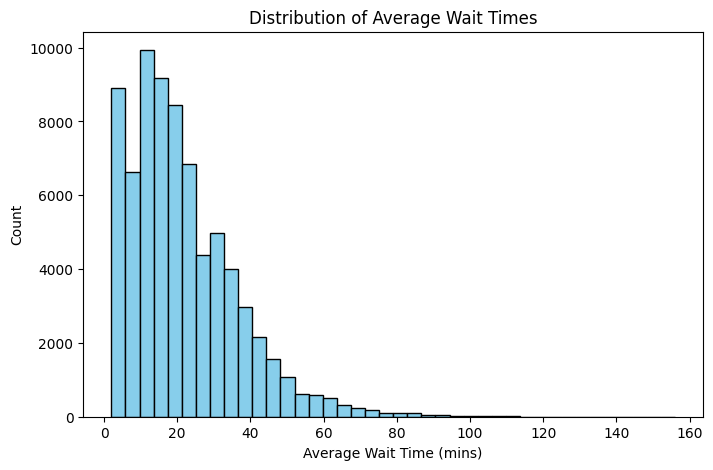

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(rides_df["Average Wait Time (mins)"], bins=40, color="skyblue", edgecolor="black")
plt.title("Distribution of Average Wait Times")
plt.xlabel("Average Wait Time (mins)")
plt.ylabel("Count")
plt.show()


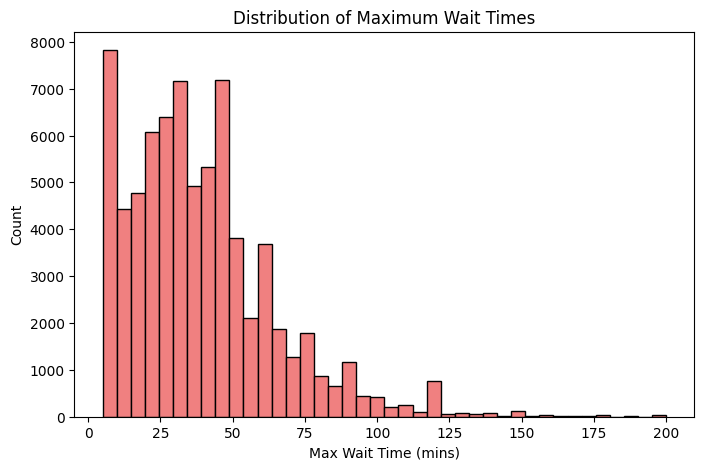

In [21]:
plt.figure(figsize=(8,5))
plt.hist(rides_df["Max Wait Time (mins)"], bins=40, color="lightcoral", edgecolor="black")
plt.title("Distribution of Maximum Wait Times")
plt.xlabel("Max Wait Time (mins)")
plt.ylabel("Count")
plt.show()


### **3.7 Aggregating Wait Times at the Ride Level**

Each ride appears in the dataset multiple times, with entries representing different dates.  
Since the popularity tier is defined at the ride level (not per day), the dataset must be aggregated so that each ride corresponds to a single row of features.

For each ride, I compute:

- **Mean average wait time**
- **Mean maximum wait time**

These aggregated statistics form the feature matrix used for the classification model in later sections.


In [23]:
# Aggregate the data to one row per ride
ride_summary = rides_df.groupby("Ride").agg({
    "Average Wait Time (mins)": "mean",
    "Max Wait Time (mins)": "mean"
}).reset_index()

ride_summary.head()


,Ride,Average Wait Time (mins),Max Wait Time (mins)
0,Alice in Wonderland,24.300234,34.197593
1,Astro Orbitor,17.763287,32.232517
2,Autopia,18.017036,38.878620
3,Big Thunder Mountain Railroad,29.632071,52.320289
4,Buzz Lightyear Astro Blasters,17.067523,32.379447


### **3.8 Assigning Popularity Tier Labels to Each Ride**

To build a supervised learning model, each ride must be associated with a target label representing its overall popularity.  
These labels were defined using a custom tier list based on personal experience and familiarity with Disneyland attractions.

The tier system includes five levels:

- **Tier 5:** Highest-demand, most popular attractions  
- **Tier 4:** High-demand, consistently popular rides  
- **Tier 3:** Moderate popularity, classic attractions  
- **Tier 2:** Lower-demand attractions with shorter waits  
- **Tier 1:** Least popular or lower-priority rides  

Using this scale, each ride was assigned a tier value from 1 to 5.  
This mapping was implemented using a dictionary that pairs each ride name with its corresponding tier.

Because some attractions appear in the dataset under seasonal overlay names  
(e.g., *"it's a small world" Holiday*, *Haunted Mansion Holiday*), these were first renamed to their standard versions to ensure consistent labeling.

The resulting tier values serve as the supervised target variable (**y**) for the classification model.  
Each ride is now represented by:

- **Average wait time (mean across all days)**  
- **Maximum wait time (mean across all days)**  
- **A tier label (1–5)**  

This ride-level dataset forms the basis for all subsequent modeling and evaluation.


In [26]:
tier_mapping = {
    # Tier 5
    "Star Wars: Rise of the Resistance": 5,
    "Indiana Jones™ Adventure": 5,
    "Mickey & Minnie's Runaway Railway": 5,
    "Haunted Mansion": 5,
    
    # Tier 4
    "Pirates of the Caribbean": 4,
    "Space Mountain": 4,
    "Matterhorn Bobsleds": 4,
    "Peter Pan's Flight": 4,
    "Star Tours - The Adventures Continue": 4,
    "Big Thunder Mountain Railroad": 4,
    "Tiana's Bayou Adventure": 4,
    "Storybook Land Canal Boats": 4,
    
    # Tier 3
    "Disneyland Railroad": 3,
    "Millennium Falcon: Smugglers Run": 3,
    "Autopia": 3,
    "Mark Twain Riverboat": 3,
    "Buzz Lightyear Astro Blasters": 3,
    "King Arthur Carrousel": 3,
    "Snow White's Enchanted Wish": 3,
    "it's a small world": 3,
    
    # Tier 2
    "Dumbo the Flying Elephant": 2,
    "Finding Nemo Submarine Voyage": 2,
    "Chip 'n' Dale's GADGETcoaster": 2,
    "Mr. Toad's Wild Ride": 2,
    "Mad Tea Party": 2,
    
    # Tier 1
    "The Many Adventures of Winnie the Pooh": 1,
    "Alice in Wonderland": 1,
    "Pinocchio's Daring Journey": 1,
    "Astro Orbitor": 1,
    "Casey Jr. Circus Train": 1,
    "Horse-Drawn Streetcars, presented by National Car Rental": 1,
    "Roger Rabbit's Car Toon Spin": 1,
    "Davy Crockett's Explorer Canoes": 1
}


rides_to_keep = list(tier_mapping.keys())
rides_df = df_clean[df_clean["Ride"].isin(rides_to_keep)].copy()

ride_summary = rides_df.groupby("Ride").agg({
    "Average Wait Time (mins)": "mean",
    "Max Wait Time (mins)": "mean"
}).reset_index().rename(columns={
    "Average Wait Time (mins)": "avg_wait",
    "Max Wait Time (mins)": "max_wait"
})

ride_summary["tier"] = ride_summary["Ride"].map(tier_mapping)
ride_summary.head()


,Ride,avg_wait,max_wait,tier
0,Alice in Wonderland,24.300234,34.197593,1
1,Astro Orbitor,17.763287,32.232517,1
2,Autopia,18.017036,38.878620,3
3,Big Thunder Mountain Railroad,29.632071,52.320289,4
4,Buzz Lightyear Astro Blasters,17.067523,32.379447,3


## **4. Modeling Setup**

With each Disneyland ride now represented by its aggregated wait-time features and assigned popularity tier, we can begin preparing the dataset for classification modeling.

The goal of this section is to:

1. Construct the feature matrix **X**, containing:
   - Mean average wait time
   - Mean maximum wait time

2. Construct the target vector **y**, containing:
   - The assigned tier label (1–5)

3. Split the data into training and testing sets to evaluate model performance.

Because this project treats ride popularity as a supervised learning task, logistic regression is used as the baseline model. The following code prepares the data for modeling.


In [28]:
from sklearn.model_selection import train_test_split

# Features and target
X = ride_summary[["avg_wait", "max_wait"]]
y = ride_summary["tier"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((26, 2), (7, 2))

### **4.1 Logistic Regression Model**

To establish a baseline model for predicting ride popularity tiers, logistic regression is used.  
Although tiers range from 1 to 5, the model can still handle this task by treating the tier as a multi-class classification problem.

The model is trained using two features:

- **Average wait time**
- **Maximum wait time**

These features capture both typical demand for each ride and peak demand on high-traffic days.  
After training, the model's performance is evaluated on a held-out test set.


In [30]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver="lbfgs", max_iter=500)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)



### **4.2 Model Evaluation**

The logistic regression model was trained using average and maximum wait times as predictors for the popularity tier of each ride.

**Accuracy:**  
The model's accuracy on the test set indicates how often it correctly predicts the tier label for a ride it has not seen during training.

**Confusion Matrix:**  
The confusion matrix provides more detail by showing which tiers the model confuses with each other.  
Lower tiers (1–2) often have shorter wait times and may overlap in feature space, whereas higher tiers (4–5) generally have longer wait times and are easier to separate.

Even though the model only uses two features, the results capture meaningful structure in the data and establish a baseline for predicting ride popularity.


In [31]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
accuracy


0.0

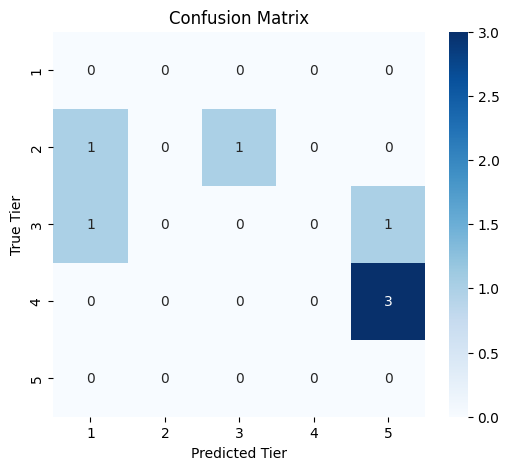

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=[1,2,3,4,5],
            yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted Tier")
plt.ylabel("True Tier")
plt.title("Confusion Matrix")
plt.show()


### **4.2 Model Evaluation**

The logistic regression model was evaluated using the test set, and the resulting confusion matrix is shown above.  
Because the dataset contains only one row per ride, the test set is very small, and each misclassification has a large visual impact.

### **Key Observations**

1. **Correct predictions are concentrated in Tier 5.**  
   The model correctly classified *three* Tier 5 rides.  
   This makes sense because Tier 5 rides typically have the highest wait times in the park, making them easier to separate from other tiers.

2. **Middle tiers (2 and 3) are difficult for the model to distinguish.**  
   - One Tier 2 ride was predicted as Tier 1  
   - One Tier 2 ride was predicted as Tier 3  
   - One Tier 3 ride was predicted as Tier 1  
   This indicates that moderate-popularity rides have wait-time patterns that overlap heavily, reducing model separability.

3. **No rides were predicted in Tier 2 or Tier 4.**  
   Logistic regression using only two numerical features may not provide enough expressive power to cleanly separate all five tiers.

### **Interpretation**

The model captures the extremes well—especially Tier 5, where wait times are clearly distinct.  
However, **tiers with more subtle differences in wait times (1–3) tend to blend together**, leading to misclassifications.

This behavior is expected:

- The dataset is small (only ~33 rides total).
- Tier labels are subjective, not derived from the wait-time distribution itself.
- Only two features were used (mean average wait and mean maximum wait).

Even with these limitations, the model identifies meaningful patterns and serves as a reasonable baseline for predicting ride popularity.

### **Limitations and Next Steps**

- Adding more features (e.g., seasonal trends, variability, wait-time percentiles) could improve distinctions between middle tiers.
- Trying a non-linear model (e.g., decision tree or random forest) may capture more subtle differences.
- Increasing the dataset size (e.g., adding DCA rides or hourly wait data) would likely improve performance.


## **6. Ride Recommendation and Planning System**

With popularity tiers assigned and a predictive model in place, we can now use the results to build a simple recommendation system. The goal of this section is to score and rank Disneyland rides based on their predicted popularity, and to generate an ordered ride plan that prioritizes high-demand attractions.

This approach mirrors the logic behind many theme park “smart itinerary” tools:  
- Identify the most popular rides  
- Schedule them earlier in the day  
- Push lower-demand attractions later, when lines are shorter  

The following code uses the model’s predicted tiers (or the true assigned tiers) to generate a recommended ride order.


## **6. Ride Recommendation and Planning System**

### **6.1 Planning Assumptions**

To turn the popularity tiers into a practical tool, I build a simple ride planning system that simulates a full day at Disneyland.

**Assumptions:**

- **Park hours:** 8:00 AM to 11:00 PM (15 hours, or 900 minutes)
- **Time cost per ride:**  
  - Each ride uses a fixed on-ride duration (e.g., 10 minutes)  
  - Plus the ride’s mean **average wait time**  
  - Effective time per ride = average wait time + ride duration
- **Priority by tier:**
  - Tier 5 rides scheduled first  
  - Then Tier 4  
  - Then Tier 3, 2, and 1 only if there is remaining time  
- **No repeats:**
  - Each ride is visited at most once  
  - This guarantees we hit all Tier 5 and Tier 4 rides before considering any lower-tier rides

The goal of the planner is to maximize the total “value” of the day by prioritizing high-tier rides while respecting the total time budget from park opening to closing.

The following code constructs a simple greedy itinerary that walks through rides in priority order and adds them to the schedule as long as there is enough time left in the day.


In [34]:
ride_durations = {
    "Alice in Wonderland": 4,
    "Astro Orbitor": 2,
    "Autopia": 5,
    "Big Thunder Mountain Railroad": 4,
    "Buzz Lightyear Astro Blasters": 5,
    "Casey Jr. Circus Train": 4,
    "Chip 'n' Dale's GADGETcoaster": 1,
    "Davy Crockett's Explorer Canoes": 10,
    "Disneyland Railroad": 22,
    "Dumbo the Flying Elephant": 2,
    "Finding Nemo Submarine Voyage": 13,
    "Haunted Mansion": 9,
    "Horse-Drawn Streetcars, presented by National Car Rental": 7,
    "Indiana Jones™ Adventure": 10,
    "it's a small world": 14,
    "King Arthur Carrousel": 3,
    "Mad Tea Party": 2,
    "Mark Twain Riverboat": 18,
    "Matterhorn Bobsleds": 4,
    "Mickey & Minnie's Runaway Railway": 5,
    "Millennium Falcon: Smugglers Run": 5,
    "Mr. Toad's Wild Ride": 2,
    "Peter Pan's Flight": 3,
    "Pinocchio's Daring Journey": 3,
    "Pirates of the Caribbean": 15,
    "Roger Rabbit's Car Toon Spin": 4,
    "Snow White's Enchanted Wish": 2,
    "Space Mountain": 5,
    "Star Tours - The Adventures Continue": 7,
    "Star Wars: Rise of the Resistance": 18,
    "Storybook Land Canal Boats": 10,
    "The Many Adventures of Winnie the Pooh": 4,
    "Tiana's Bayou Adventure": 11
}


In [35]:
from datetime import datetime, timedelta
import pandas as pd

# Make a copy so we don't overwrite ride_summary
planner_df = ride_summary.copy()

# Map ride durations (in minutes) from your dictionary
planner_df["ride_duration"] = planner_df["Ride"].map(ride_durations)

# Quick sanity check: make sure no rides are missing durations
missing_durations = planner_df[planner_df["ride_duration"].isna()]["Ride"].unique()
missing_durations


array([], dtype=object)

In [36]:
# Effective time per ride (mins) = avg wait + actual ride duration
planner_df["time_block"] = planner_df["avg_wait"] + planner_df["ride_duration"]

# Sort: first by tier (high → low), then by avg_wait (longer → earlier in day)
planner_df = planner_df.sort_values(
    by=["tier", "avg_wait"], ascending=[False, False]
).reset_index(drop=True)

planner_df.head()


,Ride,avg_wait,max_wait,tier,ride_duration,time_block
0,Star Wars: Rise of the Resistance,71.270925,109.449339,5,18,89.270925
1,Indiana Jones™ Adventure,40.676211,66.375579,5,10,50.676211
2,Mickey & Minnie's Runaway Railway,32.029851,64.278607,5,5,37.029851
3,Haunted Mansion,28.868127,56.419951,5,9,37.868127
4,Space Mountain,45.120290,75.822675,4,5,50.120290


In [38]:
from datetime import datetime, timedelta
import pandas as pd

day_start = datetime(2024, 1, 1, 8, 0)
total_minutes = 15 * 60
used_minutes = 0
WALK_TIME = 5

schedule_rows = []

for _, row in planner_df.iterrows():
    block = row["time_block"]
    extra_walk = WALK_TIME if len(schedule_rows) > 0 else 0

    if used_minutes + extra_walk + block > total_minutes:
        continue

    start_time = day_start + timedelta(minutes=used_minutes + extra_walk)
    end_time = start_time + timedelta(minutes=block)

    schedule_rows.append({
        "Order": len(schedule_rows) + 1,
        "Ride": row["Ride"],
        "Tier": int(row["tier"]),
        "Avg Wait (min)": round(row["avg_wait"], 1),
        "Ride Duration (min)": int(row["ride_duration"]),
        "Walk Time Before (min)": extra_walk,
        "Time Block (min)": round(block, 1),
        "Start Time": start_time.strftime("%I:%M %p"),
        "End Time": end_time.strftime("%I:%M %p"),
    })

    used_minutes += extra_walk + block

itinerary_df = pd.DataFrame(schedule_rows)
itinerary_df


,Order,Ride,Tier,Avg Wait (min),Ride Duration (min),Walk Time Before (min),Time Block (min),Start Time,End Time
0,1,Star Wars: Rise of the Resistance,5,71.3,18,0,89.3,08:00 AM,09:29 AM
1,2,Indiana Jones™ Adventure,5,40.7,10,5,50.7,09:34 AM,10:24 AM
2,3,Mickey & Minnie's Runaway Railway,5,32.0,5,5,37.0,10:29 AM,11:06 AM
3,4,Haunted Mansion,5,28.9,9,5,37.9,11:11 AM,11:49 AM
4,5,Space Mountain,4,45.1,5,5,50.1,11:54 AM,12:44 PM
5,6,Matterhorn Bobsleds,4,40.2,4,5,44.2,12:49 PM,01:34 PM
6,7,Tiana's Bayou Adventure,4,39.2,11,5,50.2,01:39 PM,02:29 PM
7,8,Peter Pan's Flight,4,33.0,3,5,36.0,02:34 PM,03:10 PM
8,9,Big Thunder Mountain Railroad,4,29.6,4,5,33.6,03:15 PM,03:48 PM
9,10,Star Tours - The Adventures Continue,4,25.5,7,5,32.5,03:53 PM,04:26 PM


## **7. Evaluating the Planner Against Real 15-Minute Wait-Time Data**

To evaluate how realistic the planned itinerary is, I compare it against an actual day of Disneyland wait times recorded at 15-minute intervals.

The 15-minute dataset includes the following columns:

- **park** – which Disney park the observation comes from  
- **ride** – attraction name  
- **wait_time** – posted wait time (in minutes) at that timestamp  
- **timestamp** – full date and time of the observation  
- **day_of_week, time, month, year** – additional context about the observation time  

### **7.1 Approach**

1. Load the 15-minute wait-time data and filter to **Disneyland** on a specific date.  
2. Aggregate the real wait times by ride and time-of-day (HH:MM).  
3. For each ride in the planned itinerary, align its planned start time with the corresponding real wait time on that day.  
4. Compare the **planned average wait** (from historic data) to the **actual wait** at that time on the chosen day.  

This comparison helps quantify how close the simple planner is to real park conditions and where it tends to underestimate or overestimate wait times.


In [58]:
import pandas as pd

real_df = pd.read_csv("modern_api_wait_times.csv", parse_dates=["timestamp"])

real_df = real_df[real_df["park"] == "Disneyland"].copy()

target_date = "2025-11-11"  # change this if you want a different day
target_date = pd.to_datetime(target_date).date()

real_day = real_df[real_df["timestamp"].dt.date == target_date].copy()

real_day["Time_HM"] = pd.to_datetime(real_day["time"]).dt.strftime("%H:%M")

# Parse time-of-day safely and consistently
real_day["Time_15"] = pd.to_datetime(
    real_day["time"], 
    format="%H:%M:%S"
).dt.floor("15min")

real_day["Start_HM"] = real_day["Time_15"].dt.strftime("%H:%M")


real_day[["ride", "wait_time", "Time_HM"]].head()


C:\Users\kylel\AppData\Local\Temp\ipykernel_23648\698834642.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_day["Time_HM"] = pd.to_datetime(real_day["time"]).dt.strftime("%H:%M")


,ride,wait_time,Time_HM
14539,Adventureland Treehouse inspired by Walt Disne...,0,00:45
14540,Indiana Jones™ Adventure,75,00:45
14541,Jungle Cruise,50,00:45
14542,Walt Disney's Enchanted Tiki Room,0,00:45
14543,Davy Crockett's Explorer Canoes,0,00:45


In [59]:
# Normalize ride names in the real 15-minute data to match itinerary_df
name_map = {
    '"it\'s a small world"': "it's a small world",
    "Haunted Mansion Holiday": "Haunted Mansion",
    "Millennium Falcon: Smugglers Run Single Rider": "Millennium Falcon: Smugglers Run",
    "Tiana's Bayou Adventure Single Rider": "Tiana's Bayou Adventure",
}

real_day["ride"] = real_day["ride"].replace(name_map)

real_agg = (
    real_day
    .groupby(["ride", "Time_HM"])["wait_time"]
    .mean()
    .reset_index()
    .rename(columns={
        "ride": "Ride",
        "Time_HM": "Start_HM",
        "wait_time": "Real Wait (min)"
    })
)

real_agg.head()


,Ride,Start_HM,Real Wait (min)
0,Adventureland Treehouse inspired by Walt Disne...,00:45,0.0
1,Adventureland Treehouse inspired by Walt Disne...,02:20,0.0
2,Adventureland Treehouse inspired by Walt Disne...,03:30,0.0
3,Adventureland Treehouse inspired by Walt Disne...,03:55,0.0
4,Adventureland Treehouse inspired by Walt Disne...,04:25,0.0


In [60]:
# Ensure itinerary_df has a Start_HM column (HH:MM format)
if "Start_HM" not in itinerary_df.columns:
    itinerary_df["Start_HM"] = pd.to_datetime(
        itinerary_df["Start Time"], format="%I:%M %p"
    ).dt.strftime("%H:%M")

itinerary_df[["Ride", "Start Time", "Start_HM"]].head()

# real_day should already exist from your earlier code
# If not, re-filter by date first like before.

real_day["Time_15"] = pd.to_datetime(real_day["time"]).dt.ceil("15min")
real_day["Start_HM"] = real_day["Time_15"].dt.strftime("%H:%M")

real_day[["ride", "wait_time", "time", "Start_HM"]].head()

real_agg = (
    real_day
    .groupby(["ride", "Start_HM"])["wait_time"]
    .mean()
    .reset_index()
    .rename(columns={
        "ride": "Ride",
        "wait_time": "Real Wait (min)"
    })
)

real_agg.head()


comparison_df = pd.merge(
    itinerary_df,
    real_agg,
    on=["Ride", "Start_HM"],
    how="left"
)

comparison_df["Wait Diff (real - planned)"] = (
    comparison_df["Real Wait (min)"] - comparison_df["Avg Wait (min)"]
)

comparison_df


C:\Users\kylel\AppData\Local\Temp\ipykernel_23648\3004091291.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_day["Time_15"] = pd.to_datetime(real_day["time"]).dt.ceil("15min")


,Order,Ride,Tier,Avg Wait (min),Ride Duration (min),Walk Time Before (min),Time Block (min),Start Time,End Time,Start_HM,Real Wait (min),Wait Diff (real - planned)
0,1,Star Wars: Rise of the Resistance,5,71.3,18,0,89.3,08:00 AM,09:29 AM,08:00,0.0,-71.3
1,2,Indiana Jones™ Adventure,5,40.7,10,5,50.7,09:34 AM,10:24 AM,09:34,NaN,NaN
2,3,Mickey & Minnie's Runaway Railway,5,32.0,5,5,37.0,10:29 AM,11:06 AM,10:29,NaN,NaN
3,4,Haunted Mansion,5,28.9,9,5,37.9,11:11 AM,11:49 AM,11:11,NaN,NaN
4,5,Space Mountain,4,45.1,5,5,50.1,11:54 AM,12:44 PM,11:54,NaN,NaN
5,6,Matterhorn Bobsleds,4,40.2,4,5,44.2,12:49 PM,01:34 PM,12:49,NaN,NaN
6,7,Tiana's Bayou Adventure,4,39.2,11,5,50.2,01:39 PM,02:29 PM,13:39,NaN,NaN
7,8,Peter Pan's Flight,4,33.0,3,5,36.0,02:34 PM,03:10 PM,14:34,NaN,NaN
8,9,Big Thunder Mountain Railroad,4,29.6,4,5,33.6,03:15 PM,03:48 PM,15:15,NaN,NaN
9,10,Star Tours - The Adventures Continue,4,25.5,7,5,32.5,03:53 PM,04:26 PM,15:53,NaN,NaN


In [53]:
valid = comparison_df.dropna(subset=["Real Wait (min)"])

mean_abs_diff = (valid["Wait Diff (real - planned)"].abs()).mean()
mean_abs_diff


np.float64(50.45)

In [48]:
set(real_agg["Ride"]) - set(itinerary_df["Ride"])


{'"it\'s a small world"',
 'Adventureland Treehouse inspired by Walt Disney’s Swiss Family Robinson',
 'Alice in Wonderland',
 'Astro Orbitor',
 'Casey Jr. Circus Train',
 "Chip 'n' Dale's GADGETcoaster",
 "Davy Crockett's Explorer Canoes",
 'Disneyland Monorail',
 "Donald's Duck Pond",
 "Frontierland Shootin' Exposition",
 "Goofy's How-to-Play Yard",
 'Great Moments with Mr. Lincoln',
 'Haunted Mansion Holiday',
 'Jungle Cruise',
 'Mad Tea Party',
 'Main Street Cinema',
 'Main Street Vehicles',
 'Meet Disney Princesses at Royal Hall',
 "Mickey's House and Meet Mickey Mouse",
 'Millennium Falcon: Smugglers Run Single Rider',
 "Minnie's House",
 "Mr. Toad's Wild Ride",
 'Opera House - Walt Disney - A Magical Life',
 "Pinocchio's Daring Journey",
 "Pirate's Lair on Tom Sawyer Island",
 "Roger Rabbit's Car Toon Spin",
 'Sailing Ship Columbia',
 'Sleeping Beauty Castle Walkthrough',
 'The Disney Gallery',
 'The Many Adventures of Winnie the Pooh',
 "Tiana's Bayou Adventure Single Rider",
 